In [255]:

#######################################################################
#                                                                     #
#  Copyright 2016 Theodore D Drivas                                   #
#                                                                     #
#  This file is part of pyTurbTraj.                                   #
#                                                                     #
#  pyTurbTraj is free software: you can redistribute it and/or modify #
#  it under the terms of the GNU General Public License as published  #
#  by the Free Software Foundation, either version 3 of the License,  #
#  or (at your option) any later version.                             #
#                                                                     #
#  pyTurbTraj is distributed in the hope that it will be useful,      #
#  but WITHOUT ANY WARRANTY; without even the implied warranty of     #
#  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the      #
#  GNU General Public License for more details.                       #
#                                                                     #
#  You should have received a copy of the GNU General Public License  #
#  along with pyTurbTraj.  If not, see <http://www.gnu.org/licenses/> #
#                                                                     #
#######################################################################

import numpy as np
import scipy
import matplotlib.ticker as mtick

%matplotlib nbagg
import matplotlib.pyplot as plt
from tools import *
from tools_Brownian import *

In [293]:
# for kernel density estimation

from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from scipy.special import erf

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

def approximatePDF(bw, data, grid):
    doubledData = np.concatenate((-data, data), axis=0)
    doubledGrid = np.concatenate((-grid[::-1], grid), axis=0)
    pdf = kde_scipy(doubledData, doubledGrid, bandwidth = bw)
    return  2*pdf/np.trapz(pdf)

def coarse_data(data, N):
    return np.random.choice(data, N, replace=False)

def KL_dist(pk, qk):
    return scipy.stats.entropy(pk, qk, base=None)

def L1_dist(pk, qk):
    return np.trapz(abs(pk-qk))

def subsampled_dist(Ns, replicas, bw, data, grid):
    realization_KL = np.zeros(shape=(replicas, len(Ns)))
    realization_L1 = np.zeros(shape=(replicas, len(Ns)))
    subsampledPDFs = np.zeros(shape=(len(Ns), 2*len(grid)))
    pk = approximatePDF(bw, data, grid)
    for i in range(replicas):
        for II in range(len(Ns)):
            subsampledPDFs[II,:] = approximatePDF(bw, coarse_data(data, Ns[II]), grid)
            qk = subsampledPDFs[II,:]
            realization_KL[i,II] = KL_dist(pk, qk)
            realization_L1[i,II] = L1_dist(pk, qk)
    averageKL = np.average(realization_KL, axis = 0)
    averageL1 = np.average(realization_L1, axis = 0)
    return averageL1, averageKL

def get_pairwise_dist(deltas, data, grid):
    approxPDFs = np.zeros(shape=(len(deltas), 2*len(grid)))
    for II in range(len(deltas)):
        approxPDFs[II,:] = approximatePDF(deltas[II], data, grid)
    KLdistances = np.zeros(shape = (len(deltas)-1))
    L1distances = np.zeros(shape = (len(deltas)-1))
    for II in range(len(deltas)-1): 
        pk = approxPDFs[II,:]
        qk = approxPDFs[II + 1,:]
        KLdistances[II] = KL_dist(pk, qk)
        L1distances[II] = L1_dist(pk, qk)
    return L1distances, KLdistances

def CDFofNormal(x,t):
    return (1/2.)*(1+erf(x/np.sqrt(4*kappa*t)))

def localTimeCDF(L,x0,t):
    return  2*CDFofNormal(x0+2*kappa*L,t)-1 

def localTimePDF(ell,x0,t):
    return np.sqrt(kappa/np.pi*t)*np.exp(1)**(-(x0 + 2*kappa*ell)**2/(4*kappa*t))

def stoppingTimePDF(tau,x0):
    return x0*np.exp(1)**(-x0**2/(2*kappa*tau))/np.sqrt(2*np.pi*kappa*tau**3)

In [243]:
npoints    = 1
nparticles = 2**11 #17
kappa = 1.0
nsteps = 10**5
T = 20
t  = np.linspace(T, 0, num = nsteps+1)
folder = 'data_pure_brownian/'
suffix ='_Points_{0}_Traj_{1}_Pr_{2}.p'.format(npoints, nparticles, kappa)
x       = pickle.load( open( folder + "x"     + suffix, "rb" ) )
LB      = pickle.load( open( folder + "LB"    + suffix, "rb" ) )
HT      = pickle.load( open( folder + "HT"    + suffix, "rb" ) )

<IPython.core.display.Javascript object>


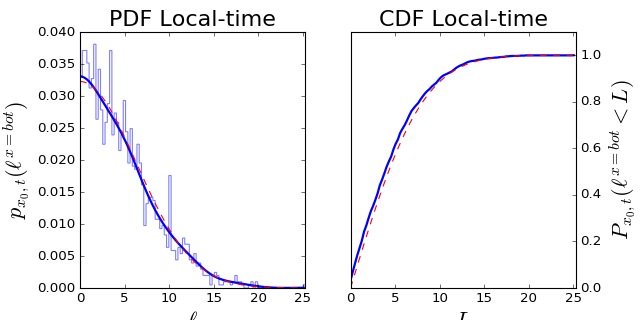

In [292]:
dataB         = LB[0,:]
MB            = np.max(dataB)

fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(hspace=.5)

####################################
######## BOTTOM LOCAL TIME #########
####################################

NN = 100
bins = np.linspace(0, MB, NN)
pdf = approximatePDF(1.37, dataB, bins)

weights = np.ones_like(dataB[:])/nparticles
ax1.hist(dataB, weights = weights, bins = bins, alpha=0.5, histtype = 'step',  color='blue')
ax1.plot(bins, pdf[len(bins):],  color='blue',lw = 2)
delta_contribution = np.zeros(bins.shape)
for i in range(bins.shape[0]/55):
    delta_contribution[i] = localTimeCDF(0, 0, t[0])
analyticalPDF = (localTimePDF(bins, 0, t[0]) + delta_contribution)/np.trapz(localTimePDF(bins, 0, t[0])+delta_contribution)
ax1.plot(bins, analyticalPDF, 'r--')

ax1.set_title('PDF Local-time', fontsize=20)
ax1.set_xlim([0,MB])
ax1.set_xlabel('$\ell$', fontsize=20)
ax1.set_ylabel('$p_{x_0,t}(\\ell^{x=bot})$', fontsize=20)

values, base = np.histogram(dataB, bins = NN, normed = 0)
cumulative   = np.cumsum(values)/float(dataB.shape[0])
ax2.plot(base[:-1], cumulative, c='blue', lw = 2)
ax2.plot(bins, localTimeCDF(bins, 0, t[0]), 'r--')

ax2.set_xlim([0,MB])
ax2.set_ylim([0,1.1])
ax2.set_title('CDF Local-time', fontsize=20)
ax2.set_xlabel('$L$', fontsize=20)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('$P_{x_0,t}(\\ell^{x=bot}<L)$', fontsize=20)

<IPython.core.display.Javascript object>


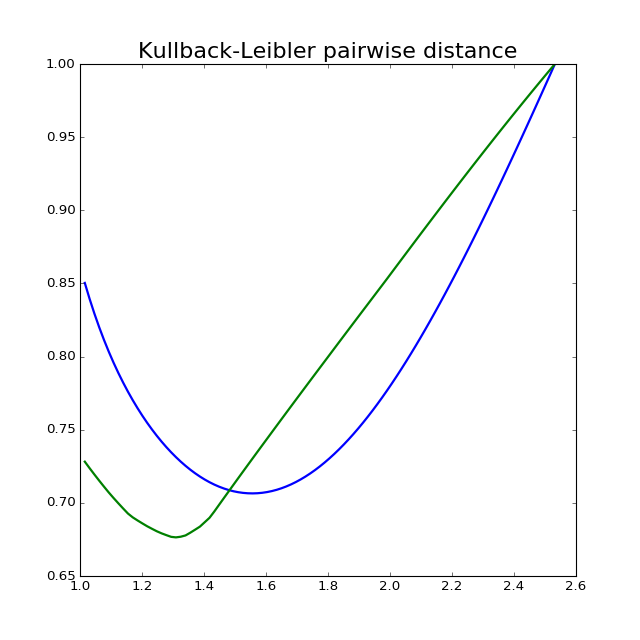

In [289]:
deltas = np.linspace(1, MB/10, 100)
L1, KS = get_pairwise_dist(deltas, dataB, bins)

fig  = plt.figure(figsize=(8,8))
ax   = fig.add_subplot(111)
ax.plot(deltas[1:], KS/max(KS), lw = 2)
ax.plot(deltas[1:], L1/max(L1), lw = 2)
ax.set_title('Kullback-Leibler pairwise distance', fontsize=20)


<IPython.core.display.Javascript object>


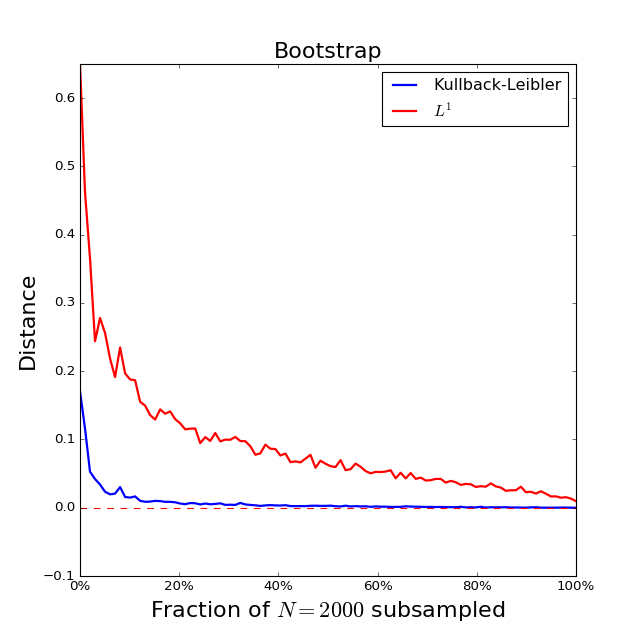

In [269]:
delta = deltas[6]
Nreps = 10
Ns   = np.array(range(20, 2020, 20))
perc = np.linspace(0,100,len(Ns))

L1, KS = subsampled_dist(Ns, Nreps, delta, dataB, bins)


fig  = plt.figure(figsize=(8,8))
ax   = fig.add_subplot(111)
ax.plot(perc, KS, c='blue', lw = 2, label = 'Kullback-Leibler')
ax.plot(perc, L1, c='red', lw = 2, label = '$L^1$')
ax.plot(perc, np.zeros(shape=100), 'r--', lw = 1)
ax.set_xlim([0,100])
ax.set_ylim([-.1,max(max(L1), max(KS))])
ax.set_title('Bootstrap', fontsize=20)
ax.set_xlabel('Fraction of $N=2000$ subsampled', fontsize=20)
ax.set_ylabel('Distance', fontsize=20)
legend = ax.legend(loc='upper right')

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)
#ax.set_xscale('log')

In [162]:
points    = 1
nparticles = 2**4
kappa = 1.0
folder = 'data_pure_brownian/history/'
suffix ='_Points_{0}_Traj_{1}_Pr_{2}.p'.format(npoints, nparticles, kappa)
xfull       = pickle.load( open( folder + "x"     + suffix, "rb" ) )
LB      = pickle.load( open( folder + "LB"    + suffix, "rb" ) )
HT      = pickle.load( open( folder + "HT"    + suffix, "rb" ) )

<IPython.core.display.Javascript object>


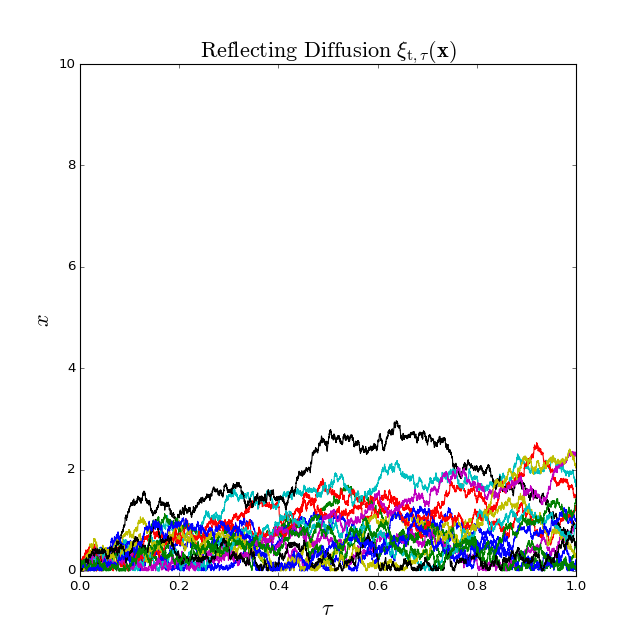

In [113]:
fig = plt.figure(figsize=(8,8))
t  = np.linspace(1, 0, num = 10**4+2)
tau = t[0]-t
ax = fig.add_subplot(111)
ax.plot(tau, xfull[:, 0, :])
ax.set_ylim([-.1,10])
ax.set_xlim([0, t[0]])
ax.set_title('$\\rm Reflecting\ Diffus ion\ {\\xi}_{t,\\tau}(\\mathbf{x})$', fontsize=20)
ax.set_xlabel('$\\tau $', fontsize=20)
ax.set_ylabel('$x$', fontsize=20)